<a href="https://colab.research.google.com/github/phonons/idapublic/blob/master/Time_dependent_Schrodinger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import sys
import os
import importlib
import glob

import matplotlib.pyplot as plt
from matplotlib import cm
import shutil
import platform

from matplotlib import animation, rc

In [0]:
# Beating in a double well potential
# A double well potential is defined. The initial condition concentrates the
# wavefunction around one of the minima. The simulation shows that, periodically, the
# energy tunnels between the two wells.

Nx = 3000						# Grid points
Ny = Nx
dt = 0.01					# Evolution step
xmax = 60					# x-window size
ymax = xmax					# y-window size
absorb_coeff = 20		# 0 = periodic boundary

In [0]:
increments_between_frames = 40 # how many iterations need to be calculated between shown images

In [0]:
animation_frame_interval = 50
number_of_frames = 100
tmax = dt * number_of_frames * animation_frame_interval #total length of the simulation

In [0]:
def grid(Nx,Ny,xmax,ymax):
	x = np.linspace(-xmax, xmax-2*xmax/Nx, Nx)     # x variable
	y = 0                 # not used, but a value must be given
	return x,y;

# Builds the Laplacian in Fourier space

def Lfnc(Nx,Ny,xmax,ymax):
	kx = np.linspace(-Nx/4/xmax, Nx/4/xmax-1/2/xmax, Nx)     # x variable
	return (2*np.pi*1.j*kx)**2 

# Introduces an absorbing shell at the border of the computational window

def absorb(x,y,xmax,ymax,dt,absorb_coeff):
	wx = xmax/20
	return np.exp(-absorb_coeff*(2-np.tanh((x+xmax)/wx)+np.tanh((x-xmax)/wx))*dt);

# Saves the data of abs(psi)**2 at different values of t

def savepsifnc(Ny,psi):
	
	return abs(psi)**2   		    

In [0]:
def psi_0(x,y):				# Initial wavefunction

	f = 0.j+np.exp(-((x-1)**2)/2)   # A Gaussian centered at one of the wells

	return f;

In [0]:
# Initialization of the computation

def init_values():
  
  global x,y,psi,L,linear_phase,border

  x, y = grid(Nx,Ny,xmax,ymax)		# builds spatial grid
  psi = psi_0(x,y) 					# loads initial condition

  L = Lfnc(Nx,Ny,xmax,ymax)		# Laplacian in Fourier space
  linear_phase = np.fft.fftshift(np.exp(1.j*L*dt/2))            	# linear phase in Fourier space (including point swap)
  border = absorb(x,y,xmax,ymax,dt,absorb_coeff)    # Absorbing shell at the border of the computational window

init_values()  

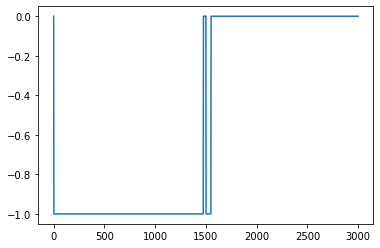

In [0]:
def Vfnc1(x,y,t,psi):		# A double well potential

	b_min=-60
	b_max=-1
	l_2= (b_max - b_min)/2  #half of the width of the left well
	center=(b_max + b_min)/2

	V = np.piecewise(x, [abs(x-1)<1, abs(x-1)>=1],[-1,0]) + np.piecewise(x, [abs(x-center)<l_2, abs(x-center)>=l_2],[-1,0]) #V equal
	return V;

Vname = "Vfnc1"
V = globals()[Vname](x,y,dt,psi)
plt.plot(V)  

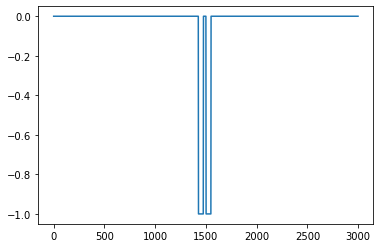

In [0]:
def Vfnc2(x,y,t,psi):		# A double well potential

	V = np.piecewise(x, [abs(x-1)<1, abs(x-1)>=1],[-1,0]) + np.piecewise(x, [abs(x+2)<1, abs(x+2)>=1],[-1,0])
	return V;

Vname = "Vfnc2"
V = globals()[Vname](x,y,dt,psi)
plt.plot(V)    

In [0]:
#setting up the empty plot 

def init_figure():
  
  global fig,ax,psi_x_line,V_x_line

  fig, ax = plt.subplots()
  plt.xlabel('$x$')           # format LaTeX if installed (choose axes labels, 
  plt.ylabel('$|\psi|^2$')    # title of the plot and axes range
  #plt.title('$t=$ %f'%(t))    # title of the plot
  plt.close()

  ax.set_xlim((min(x),max(x)))
  ax.set_ylim((-2, 2))

  psi_x_line, = ax.plot([], [], lw=2)
  V_x_line, = ax.plot([], [], lw=2)

#def init():
#    psi_x_line.set_data([], [])
#    V_x_line.set_data([], [])
#    return (psi_x_line, V_x_line)

In [0]:
# defining animation function which contains the stepwise calculation 

def animate(k,Vname): # k counts the frame number we are on
	
	global psi,x,y,all_psi

	for i in range(increments_between_frames): # before moving on to the next frame, we caclulate that many intermediate steps of the small dt increment
		j = (k*increments_between_frames)+i # the global counting variable j is the product of the frame we are on and the increments per frame 
		# i.e. the total number of increments dt processed so far
		
		V = globals()[Vname](x,y,j*dt,psi)			# potential operator
		psi *= np.exp(-1.j*dt*V)			# potential phase
		psi = np.fft.fft(psi)			# 1D Fourier transform
		psi *=linear_phase		        # linear phase from the Laplacian term
		psi = border*np.fft.ifft(psi)	# inverse Fourier transform and damping by the absorbing shel
		
	print(".", end="", flush=True)
	psi_x_line.set_data(x, abs(psi)**2)
	V_x_line.set_data(x,V) # the last read value of V 

	all_psi.append(psi)

In [0]:
# call the animator
init_values()
init_figure()

all_psi = list()

Vname = "Vfnc1"
anim = animation.FuncAnimation(fig, animate, fargs=[Vname], #init_func=init,
                               frames=number_of_frames, interval=animation_frame_interval, blit=False) #
# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim

.....................................................................................................

In [0]:
print(len(all_psi))
all_psi[1]

101


array([ 2.12310192e-05+2.80185099e-06j, -2.60253287e-05-8.71926496e-06j,
        3.07654905e-05+1.36133778e-05j, ...,
       -1.00610274e-05+1.82813297e-05j,  1.28870825e-05-1.07631117e-05j,
       -1.67409230e-05+3.68470668e-06j])

In [0]:
# call the animator
init_values()
init_figure()

Vname = "Vfnc2"
anim = animation.FuncAnimation(fig, animate, fargs=[Vname], #init_func=init,
                               frames=100, interval=50, blit=False) #
# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim

.....................................................................................................

In [0]:
psi

array([-8.97749899e-05-5.31650412e-04j,  8.10879400e-05+9.56930930e-05j,
        1.19013247e-04+3.33901209e-04j, ...,
       -8.92908260e-05-3.49053479e-04j, -1.26113528e-04+2.93562497e-04j,
        1.70411620e-04+2.80487813e-04j])